# Intro to PyMC codebase

Tags: Aesara, AePPL, PyMC, RandomVariable, Distribution, Model, logp

**Authors:** [Ricardo Vieira](https://github.com/ricardoV94) and [Juan Orduz](https://juanitorduz.github.io/)

For a summary overview please see [Architecture.md](https://github.com/pymc-devs/pymc/blob/main/ARCHITECTURE.md)

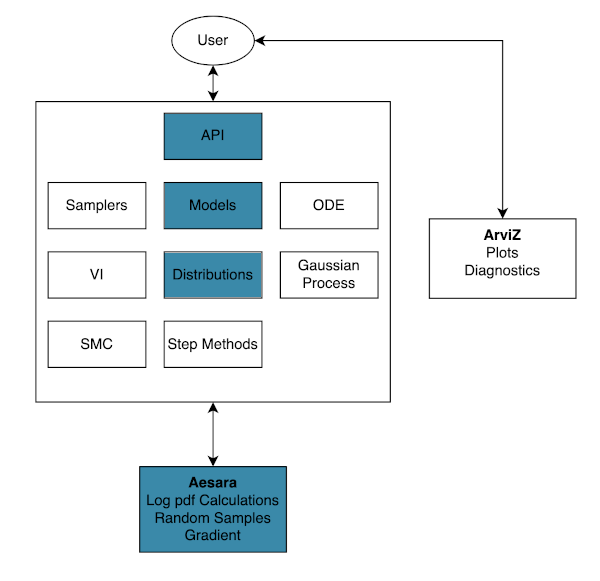



## Prepare Notebook

Let us first import the required libraries.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

import aesara
import aesara.tensor as at

import pymc as pm
aesara.__version__, pm.__version__

('2.5.1', '4.0.0b6')

## Intro to Aesara

We start by looking into [aesara](https://github.com/aesara-devs/aesara/). According to their documentation

> Aesara is a Python library that allows one to define, optimize, and efficiently evaluate mathematical expressions involving multi-dimensional arrays.

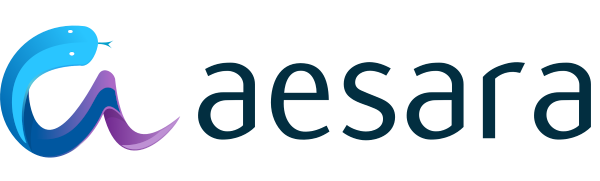

### A simple example

To begin, we start defining some aesara tensors and perform some basic operations.

In [2]:
x = at.scalar(name="x")
y = at.vector(name="y")

print(f"""
x type: {x.type}
x name = {x.name}
---
y type: {y.type}
y name = {y.name}
""")


x type: TensorType(float64, ())
x name = x
---
y type: TensorType(float64, (None,))
y name = y



In [3]:
z = x + y
z.name = "x + y"
w = at.log(z)
w.name = "log(x + y)"

We can use the [`aesara.dprint`](https://aesara.readthedocs.io/en/latest/library/index.html#aesara.dprint) function to print the computational graph of the given tensor.

In [4]:
aesara.dprint(obj=w)

Elemwise{log,no_inplace} [id A] 'log(x + y)'   
 |Elemwise{add,no_inplace} [id B] 'x + y'   
   |InplaceDimShuffle{x} [id C] ''   
   | |x [id D]
   |y [id E]


The aesara function [`aesara.function`](https://aesara.readthedocs.io/en/latest/library/compile/function.html#aesara.compile.function.function) is used to define a callable object so that we can push values trough the graph.

In [5]:
# we compile the graph with numba (conda install -c numba numba)
f = aesara.function(inputs=[x, y], outputs=w, mode="NUMBA")

Let's run some concrete values.

In [6]:
# keyword arguments only valid for named variables
f(x=0, y=[1, np.e])

array([0., 1.])

Sometimes we just want to debug, we can use `eval` for that:

In [7]:
w.eval({x: 0, y:[1, np.e]})

array([0., 1.])

You can set intermediate values as well

In [8]:
# You can set intermediate values as well
w.eval({z: [1, np.e]})

array([0., 1.])

### What is in an Aesara graph?

The following diagram shows the basic structure of an Aesara graph.

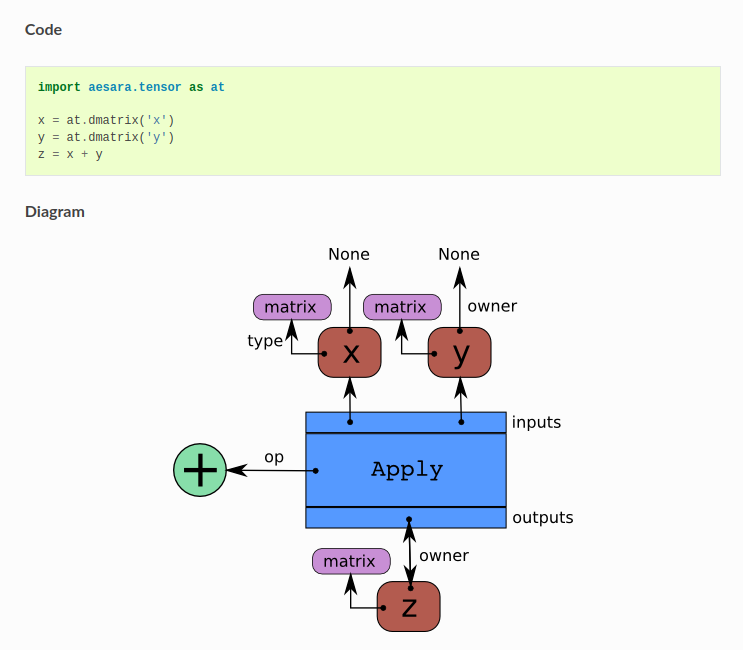

We can can make these concepts more tangible trough the example above: 

In [9]:
print(f"""
z type: {z.type}
z name = {z.name}
z owner = {z.owner}
z owner inputs = {z.owner.inputs}
z owner op = {z.owner.op}
z owner output = {z.owner.outputs}
""")


z type: TensorType(float64, (None,))
z name = x + y
z owner = Elemwise{add,no_inplace}(InplaceDimShuffle{x}.0, y)
z owner inputs = [InplaceDimShuffle{x}.0, y]
z owner op = Elemwise{add,no_inplace}
z owner output = [x + y]



The following sniped of code helps us to understand these concepts by going through the computational graph.

In [10]:
from aesara.tensor.elemwise import Elemwise

stack = [w]

while stack:
    print("---")
    var = stack.pop(0)
    print(f"Checking variable {var} of type {var.type}")
    # check variable is not a root variable
    if var.owner is not None:
        print(f" > Op is {var.owner.op}")
        # loop over the inputs
        for i, input in enumerate(var.owner.inputs):
            print(f" > Input {i} is {input}")
            stack.append(input)
    else:
        print(f" > {var} is a root variable")

---
Checking variable log(x + y) of type TensorType(float64, (None,))
 > Op is Elemwise{log,no_inplace}
 > Input 0 is x + y
---
Checking variable x + y of type TensorType(float64, (None,))
 > Op is Elemwise{add,no_inplace}
 > Input 0 is InplaceDimShuffle{x}.0
 > Input 1 is y
---
Checking variable InplaceDimShuffle{x}.0 of type TensorType(float64, (1,))
 > Op is InplaceDimShuffle{x}
 > Input 0 is x
---
Checking variable y of type TensorType(float64, (None,))
 > y is a root variable
---
Checking variable x of type TensorType(float64, ())
 > x is a root variable


Note that this is very similar to the output of the  [`aesara.dprint`](https://aesara.readthedocs.io/en/latest/library/index.html#aesara.dprint) function introduced above.

In [11]:
aesara.dprint(w)

Elemwise{log,no_inplace} [id A] 'log(x + y)'   
 |Elemwise{add,no_inplace} [id B] 'x + y'   
   |InplaceDimShuffle{x} [id C] ''   
   | |x [id D]
   |y [id E]


### Graph manipulation 101

Now, we describe how to manipulate the computational graph. We continue with our tensors above to illustrate how to do it.

In [12]:
# get input tensors
list(aesara.graph.graph_inputs(graphs=[w]))

[x, y]

As a simple example, let's add an `exp` before the `log` (to get the identity function).

In [13]:
parent_of_w = w.owner.inputs[0] # get z tensor
new_parent_of_w = at.exp(parent_of_w) # modify the parent of w
new_parent_of_w.name = "exp(x + y)"

Note that the graph of `w` has actually not change:

In [14]:
aesara.dprint(w)

Elemwise{log,no_inplace} [id A] 'log(x + y)'   
 |Elemwise{add,no_inplace} [id B] 'x + y'   
   |InplaceDimShuffle{x} [id C] ''   
   | |x [id D]
   |y [id E]


To modify the graph we need to use the [`aesara.clone_replace`](https://aesara.readthedocs.io/en/latest/library/index.html?highlight=clone_replace#aesara.clone_replace) function, which *returns a copy of the initial subgraph with the corresponding substitutions.*

In [15]:
new_w = aesara.clone_replace(output=[w], replace={parent_of_w: new_parent_of_w})[0]
new_w.name = "exp(log(x + y))"
aesara.dprint(new_w)

Elemwise{log,no_inplace} [id A] 'exp(log(x + y))'   
 |Elemwise{exp,no_inplace} [id B] 'exp(x + y)'   
   |Elemwise{add,no_inplace} [id C] 'x + y'   
     |InplaceDimShuffle{x} [id D] ''   
     | |x [id E]
     |y [id F]


Finally, we can test the modified graph by passing some input to the new graph.

In [16]:
new_w.eval({x: 0, y:[1, np.e]})

array([1.        , 2.71828183])

### Aesara is clever!
Note that aesara is clever enough to omit the `exp` and `log` unnecessary composition.

In [17]:
f = aesara.function(inputs=[x, y], outputs=new_w, mode="JAX")

aesara.dprint(f)

Elemwise{add,no_inplace} [id A] 'x + y'   1
 |InplaceDimShuffle{x} [id B] ''   0
 | |x [id C]
 |y [id D]


/Users/juanitorduz/opt/anaconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")


In [18]:
f(x=0, y=[1, np.e])

DeviceArray([1.        , 2.71828183], dtype=float64)

## Aesara RandomVariables

Now that we have seen aesara's basics we want to move in the direction of random variables. Here are the modules we want to cover:

* [Random Module](https://github.com/aesara-devs/aesara/tree/main/aesara/tensor/random)
* [RandomVariable Op](https://github.com/aesara-devs/aesara/blob/main/aesara/tensor/random/op.py)
* [Random Variables](https://github.com/aesara-devs/aesara/blob/main/aesara/tensor/random/basic.py)

How To generate random numbers in `numpy`?

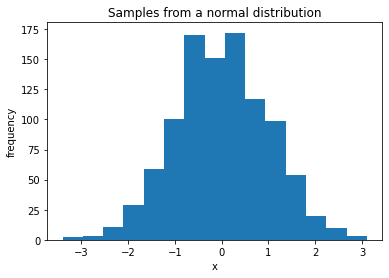

In [19]:
rng = np.random.default_rng()

a = rng.normal(loc=0, scale=1, size=1000)

fig, ax = plt.subplots()
ax.hist(a, bins=15)
ax.set(
    title="Samples from a normal distribution", xlabel="x", ylabel="frequency"
);

Now let's do it in aesara.

In [20]:
x = at.random.normal(loc=0.0, scale=1.0, size=None, name="x")

print(f"""
x type: {x.type}
x name = {x.name}
"""
)


x type: TensorType(float64, ())
x name = x



In [21]:
aesara.dprint(x)

normal_rv{0, (0, 0), floatX, False}.1 [id A] 'x'   
 |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x15E2A94A0>) [id B]
 |TensorConstant{[]} [id C]
 |TensorConstant{11} [id D]
 |TensorConstant{0.0} [id E]
 |TensorConstant{1.0} [id F]


Inputs are always in the following order:
1. rng shared variable
2. size
3. dtype (number code)
4. arg1
5. arg2
6. argn

### Some meta-properties worth knowing about

The `op` of `x`'s `owner` is:

In [22]:
op = x.owner.op

op

In [23]:
print(f"""
op ndim_supp    = {op.ndim_supp}        (Dimension of draws (0=scalar, 1=vector, 2=matrix, etc.))
op ndims_params = {op.ndims_params}   (Dimension of each parameter)
op.dtype        = {op.dtype}
""")


op ndim_supp    = 0        (Dimension of draws (0=scalar, 1=vector, 2=matrix, etc.))
op ndims_params = (0, 0)   (Dimension of each parameter)
op.dtype        = floatX



### RandomVariables use `SharedVariables` for seeding

By default draws don't change between calls

In [24]:
for i in range(10):
    print(f"sample {i}: {x.eval()}")

sample 0: 0.669978181137517
sample 1: 0.669978181137517
sample 2: 0.669978181137517
sample 3: 0.669978181137517
sample 4: 0.669978181137517
sample 5: 0.669978181137517
sample 6: 0.669978181137517
sample 7: 0.669978181137517
sample 8: 0.669978181137517
sample 9: 0.669978181137517


This is because the `RandomOp` is a deterministic operation, given it's inputs. One of these inputs is a `RandomGenerator/State`.

In [25]:
print(f"""
x owner = {x.owner.inputs[0]}
x owner's input = {x.owner.inputs[0].type}
""")


x owner = RandomGeneratorSharedVariable(<Generator(PCG64) at 0x15E2A94A0>)
x owner's input = RandomGeneratorType



This input is created by default, but can be passed explicitly as well

In [26]:
rng = np.random.default_rng(seed=123)
shared_rng = aesara.shared(value=rng, borrow=True)
y = at.random.normal(loc=0, scale=1, rng=shared_rng, size=2, name="y")
aesara.dprint(y)

normal_rv{0, (0, 0), floatX, False}.1 [id A] 'y'   
 |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x15FD8E580>) [id B]
 |TensorConstant{(1,) of 2} [id C]
 |TensorConstant{11} [id D]
 |TensorConstant{0} [id E]
 |TensorConstant{1} [id F]


Each draw in the same call is unique, but these again don't change across calls:

In [27]:
for i in range(10):
    print(f"sample {i}: {y.eval()}")

sample 0: [-0.98912135 -0.36778665]
sample 1: [-0.98912135 -0.36778665]
sample 2: [-0.98912135 -0.36778665]
sample 3: [-0.98912135 -0.36778665]
sample 4: [-0.98912135 -0.36778665]
sample 5: [-0.98912135 -0.36778665]
sample 6: [-0.98912135 -0.36778665]
sample 7: [-0.98912135 -0.36778665]
sample 8: [-0.98912135 -0.36778665]
sample 9: [-0.98912135 -0.36778665]


How to generate different samples? We can  make the generator advance by one, which will make the draws "cycle" by one.

In [28]:
for i in range(10):
    rng.bit_generator.advance(1)
    print(f"sample {i}: {y.eval()}")

sample 0: [-0.36778665  1.28792526]
sample 1: [1.28792526 0.19397442]
sample 2: [0.19397442 0.9202309 ]
sample 3: [0.9202309  0.57710379]
sample 4: [ 0.57710379 -0.63646365]
sample 5: [-0.63646365  0.54195222]
sample 6: [ 0.54195222 -0.31659545]
sample 7: [-0.31659545 -0.32238912]
sample 8: [-0.32238912  0.09716732]
sample 9: [ 0.09716732 -1.52593041]


Now the draws are completely different than the initial ones.

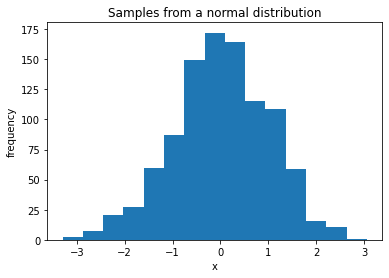

In [29]:
samples = []
for _ in range(1000):
    rng.bit_generator.advance(1)
    samples.append(y.eval()[0])

fig, ax = plt.subplots()
ax.hist(samples, bins=15)
ax.set(
    title="Samples from a normal distribution", xlabel="x", ylabel="frequency"
);

### Updating the `RandomState` manually is cumbersome

So `RandomVariable`s do it for us

In [30]:
rng = np.random.default_rng(seed=123)
shared_rng = aesara.shared(value=rng, borrow=True)
z = at.random.normal(loc=0, scale=1, rng=shared_rng, name="z")

aesara.dprint(z)

normal_rv{0, (0, 0), floatX, False}.1 [id A] 'z'   
 |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x15FF65580>) [id B]
 |TensorConstant{[]} [id C]
 |TensorConstant{11} [id D]
 |TensorConstant{0} [id E]
 |TensorConstant{1} [id F]


Notice that there are 2 outputs

In [31]:
for output in z.owner.outputs:
    print(f"output: {output}")

output: normal_rv{0, (0, 0), floatX, False}.0
output: z


The first one is of `RandomGeneratorType`.

In [32]:
next_rng = z.owner.outputs[0]
next_rng.type

RandomGeneratorType

From the discussion above it is not surprising that evaluating `z` will yield to the same result:

In [33]:
for i in range(10):
    print(f"sample {i}: {z.eval()}")

sample 0: -0.9891213503478509
sample 1: -0.9891213503478509
sample 2: -0.9891213503478509
sample 3: -0.9891213503478509
sample 4: -0.9891213503478509
sample 5: -0.9891213503478509
sample 6: -0.9891213503478509
sample 7: -0.9891213503478509
sample 8: -0.9891213503478509
sample 9: -0.9891213503478509


We can set the input RNG to the next RNG state returned by the `RandomVariable`

In [34]:
for i in range(10):
    next_rng_value = next_rng.eval()
    shared_rng.set_value(next_rng_value)
    print(f"sample {i}: {z.eval()}")

sample 0: -0.3677866514678832
sample 1: 1.2879252612892487
sample 2: 0.1939744191326132
sample 3: 0.9202308996398569
sample 4: 0.5771037912572513
sample 5: -0.6364636463709805
sample 6: 0.5419522204102933
sample 7: -0.3165954511658161
sample 8: -0.32238911615896015
sample 9: 0.09716731867045719


### Almost there

The final step is to make use of default_updates in shared variables

In [35]:
rng = np.random.default_rng(seed=123)
shared_rng = aesara.shared(rng, borrow=True)
w = at.random.normal(loc=0, scale=1, rng=shared_rng, name="w")
next_rng = w.owner.outputs[0]

We set a symbolic update. Every time the function is called, the value of rng shared variable is set to the first output (the next rng state) of the random variable.

In [36]:
shared_rng.default_update = next_rng

In [37]:
for i in range(10):
    print(f"sample {i}: {w.eval()}")

sample 0: -0.9891213503478509
sample 1: -0.3677866514678832
sample 2: 1.2879252612892487
sample 3: 0.1939744191326132
sample 4: 0.9202308996398569
sample 5: 0.5771037912572513
sample 6: -0.6364636463709805
sample 7: 0.5419522204102933
sample 8: -0.3165954511658161
sample 9: -0.32238911615896015


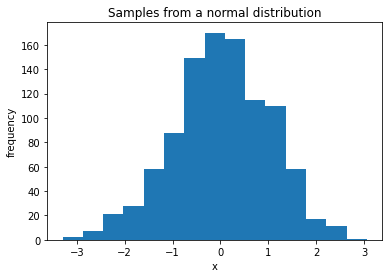

In [38]:
samples = np.array([w.eval() for _ in range(1000)])

fig, ax = plt.subplots()
ax.hist(samples, bins=15)
ax.set(
    title="Samples from a normal distribution", xlabel="x", ylabel="frequency"
);

### Graph manipulation 102

Replacing `sum(bernoulli(p, size))` by `binomial(size, p)`

In [39]:
p = at.scalar("p")
rng = aesara.shared(np.random.default_rng(0))
b = at.random.bernoulli(p, size=10, rng=rng)
bs = at.sum(b)
nbs = - bs

# example
nbs.eval({p: 0.5})

array(-7)

In [40]:
aesara.dprint(nbs)

Elemwise{neg,no_inplace} [id A] ''   
 |Sum{acc_dtype=int64} [id B] ''   
   |bernoulli_rv{0, (0,), int64, False}.1 [id C] ''   
     |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x16001CBA0>) [id D]
     |TensorConstant{(1,) of 10} [id E]
     |TensorConstant{4} [id F]
     |p [id G]


In [41]:
from aesara.graph import FunctionGraph
from aesara.graph.opt import in2out, local_optimizer
from aesara.tensor.math import Sum
from aesara.tensor.random.basic import BernoulliRV

In [42]:
@local_optimizer(tracks=None)
def local_sum_bernoulli_to_binomial(fgraph, node):
    """This local rewrite replaces a sum(bern(p=p, size=size)) by binom(n=size, p=p)"""

    # Check we have a Sum node with axis = None
    if isinstance(node.op, Sum) and node.op.axis is None:
        # Check input is a bernoulli variable
        bern = node.inputs[0]
        if bern.owner is not None and isinstance(bern.owner.op, BernoulliRV):
            # Check that size and p are scalar
            rng, size, dtype, p = bern.owner.inputs
            if at.get_vector_length(size) == 1 and p.ndim == 0:
                # Return binomial as replacement
                binom = at.random.binomial(size[0], p, rng=rng, dtype=dtype)
                return [binom]

    return None

In [43]:
my_optimizer = in2out(local_sum_bernoulli_to_binomial)

In [44]:
fgraph = FunctionGraph(outputs=[nbs], clone=False)
aesara.dprint(fgraph)

Elemwise{neg,no_inplace} [id A] ''   2
 |Sum{acc_dtype=int64} [id B] ''   1
   |bernoulli_rv{0, (0,), int64, False}.1 [id C] ''   0
     |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x16001CBA0>) [id D]
     |TensorConstant{(1,) of 10} [id E]
     |TensorConstant{4} [id F]
     |p [id G]


In [45]:
my_optimizer.optimize(fgraph)

(<aesara.graph.opt.TopoOptimizer at 0x160070b80>,
 1,
 3,
 3,
 2.288818359375e-05,
 0.0025620460510253906,
 2.2649765014648438e-05,
 FromFunctionLocalOptimizer(<function local_sum_bernoulli_to_binomial at 0x16006b5e0>, None, ()))

In [46]:
aesara.dprint(fgraph)

Elemwise{neg,no_inplace} [id A] ''   2
 |binomial_rv{0, (0, 0), int64, False}.1 [id B] ''   1
   |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x16001CBA0>) [id C]
   |TensorConstant{[]} [id D]
   |TensorConstant{4} [id E]
   |Subtensor{int64} [id F] ''   0
   | |TensorConstant{(1,) of 10} [id G]
   | |ScalarConstant{0} [id H]
   |p [id I]


In [47]:
# Binomial and bernoulli do not have the same draws, given the same seed, so the results can vary
# The seed was chosen to illustrate this!
fgraph.outputs[0].eval({p: 0.5})

array(-7)

# PyMC

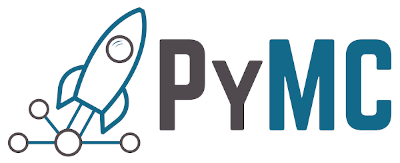

## Distributions are just RandomVariables

**Source code**
* [PyMC [rev 1005d20b3c]](https://github.com/pymc-devs/pymc/tree/1005d20b3c12d9b9a424c069f6a0f9962d73c41d)
* [Distributions module](https://github.com/pymc-devs/pymc/tree/main/pymc/distributions)
* [Distribution class](https://github.com/pymc-devs/pymc/blob/main/pymc/distributions/distribution.py)
    * See issue [#5308](https://github.com/pymc-devs/pymc/issues/5308)
* [Discrete distributions](https://github.com/pymc-devs/pymc/blob/main/pymc/distributions/discrete.py)
* [Continuous distributions](https://github.com/pymc-devs/pymc/blob/main/pymc/distributions/continuous.py)
* [Multivariate distributions](https://github.com/pymc-devs/pymc/blob/main/pymc/distributions/multivariate.py)

**Guide**
* [Distribution developer guide](https://github.com/pymc-devs/pymc/blob/1005d20b3c12d9b9a424c069f6a0f9962d73c41d/docs/source/contributing/developer_guide_implementing_distribution.md)

In [48]:
x = pm.Normal.dist(mu=0, tau=2, shape=3)
aesara.dprint(x)

normal_rv{0, (0, 0), floatX, False}.1 [id A] ''   
 |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x16005CE40>) [id B]
 |TensorConstant{(1,) of 3} [id C]
 |TensorConstant{11} [id D]
 |TensorConstant{0} [id E]
 |TensorConstant{0.7071067811865476} [id F]


In [49]:
x.eval(), x.eval()

(array([-0.27951064, -0.01859431,  1.13900724]),
 array([-0.27951064, -0.01859431,  1.13900724]))

In [50]:
with pm.Model() as model:
    x = pm.Normal("x", mu=np.array([0, 0]), tau=np.array([1, 2]), size=2)
aesara.dprint(x)

normal_rv{0, (0, 0), floatX, False}.1 [id A] 'x'   
 |RandomStateSharedVariable(<RandomState(MT19937) at 0x15FFC0640>) [id B]
 |TensorConstant{(1,) of 2} [id C]
 |TensorConstant{11} [id D]
 |TensorConstant{(2,) of 0} [id E]
 |TensorConstant{[1.       ...70710678]} [id F]


In [51]:
# Variables are already seeded, but we might change this behavior in the future
x.eval(), x.eval()

(array([-1.27348455,  0.38980554]), array([-1.27348455,  0.38980554]))

In [52]:
# The CORRECT way to draw values is to use `pm.draw`
pm.draw(x, draws=2)

array([[-1.27348455,  0.38980554],
       [ 1.28056807, -0.33584146]])

## What is going on behind the scenes?

**Source code**
* [Model module](https://github.com/pymc-devs/pymc/blob/main/pymc/model.py)

In [53]:
model.basic_RVs

[x]

In [54]:
aesara.dprint(model.basic_RVs[0])

normal_rv{0, (0, 0), floatX, False}.1 [id A] 'x'   
 |RandomStateSharedVariable(<RandomState(MT19937) at 0x15FFC0640>) [id B]
 |TensorConstant{(1,) of 2} [id C]
 |TensorConstant{11} [id D]
 |TensorConstant{(2,) of 0} [id E]
 |TensorConstant{[1.       ...70710678]} [id F]


In [55]:
# Manual variable registration
with pm.Model() as model:
    # my_x = pm.Normal("x", 0, tau=5)
    my_x = pm.Normal.dist(0, 1)
    model.register_rv(
        rv_var=my_x,
        name="my_x",
        data=None,
        total_size=None,
        dims=None,
        transform=None,
        initval="prior",
    )
model.rvs_to_values

{my_x: my_x}

## Enough with Random Variables, I want to see some (log)probabilities!

**Source code**
* [PyMC logprob](https://github.com/pymc-devs/pymc/blob/1005d20b3c12d9b9a424c069f6a0f9962d73c41d/pymc/distributions/logprob.py)
* [Aeppl logprob](https://github.com/aesara-devs/aeppl/blob/2019114d231d8d3d96acc284fe0e6ee42d89c912/aeppl/logprob.py)

In [66]:
point = model.compute_initial_point()
point

{'my_x': array(-0.09312973)}

In [67]:
model.point_logps(point)

{'my_x': -0.92}

In [58]:
from aeppl.logprob import _logprob

In [ ]:
_logprob.registry

In [69]:
x = pm.Normal.dist(size=2)
x.owner.op

In [70]:
x_logp = _logprob(x.owner.op, ([0, 0],), *x.owner.inputs)
aesara.dprint(x_logp)

Check{sigma > 0} [id A] ''   
 |Elemwise{sub,no_inplace} [id B] ''   
 | |Elemwise{sub,no_inplace} [id C] ''   
 | | |Elemwise{mul,no_inplace} [id D] ''   
 | | | |InplaceDimShuffle{x} [id E] ''   
 | | | | |TensorConstant{-0.5} [id F]
 | | | |Elemwise{pow,no_inplace} [id G] ''   
 | | |   |Elemwise{true_div,no_inplace} [id H] ''   
 | | |   | |Elemwise{sub,no_inplace} [id I] ''   
 | | |   | | |TensorConstant{(2,) of 0} [id J]
 | | |   | | |InplaceDimShuffle{x} [id K] ''   
 | | |   | |   |TensorConstant{0} [id L]
 | | |   | |InplaceDimShuffle{x} [id M] ''   
 | | |   |   |TensorConstant{1.0} [id N]
 | | |   |InplaceDimShuffle{x} [id O] ''   
 | | |     |TensorConstant{2} [id P]
 | | |InplaceDimShuffle{x} [id Q] ''   
 | |   |Elemwise{log,no_inplace} [id R] ''   
 | |     |Elemwise{sqrt,no_inplace} [id S] ''   
 | |       |TensorConstant{6.283185307179586} [id T]
 | |InplaceDimShuffle{x} [id U] ''   
 |   |Elemwise{log,no_inplace} [id V] ''   
 |     |TensorConstant{1.0} [id N]
 |All 

In [72]:
x_logp.eval()

array([-0.91893853, -0.91893853])

In [73]:
# Helper friendly pymc function to access logp
# Takes RV + value as input
pm.logp(x, [0, 0]).eval()

array([-0.91893853, -0.91893853])

In [74]:
# What about other types of Ops?
try:
    y = at.cumsum(x)
    pm.logp(y, [1, 1])
except NotImplementedError as err:
    print(err)

Logprob method not implemented for CumOp{None, add}


Note: A similar dispatch strategy is used for `logcdf` and `get_moment`

## What is the deal with those value variables in the model?

* RVs for random draws
* Value variables for logprob evaluations

In [65]:
# RV and value variables can be observed in these scipy operations
(
    scipy.stats.norm(0, 1),  # Equivalent to rv = pm.Normal("rv", 0, 1)
    rv.rvs(5),               # Equivalent to rv_draw = pm.draw(rv, 5)
    rv.logpdf(1.25),         # Equivalent to rv_logp = pm.logp(rv, .125)
)

NameError: name 'rv' is not defined

In [75]:
with pm.Model() as m:
    sigma = pm.HalfNormal("sigma")
    x = pm.Normal("x", 0, sigma=sigma)

In [77]:
# Each model RV is related to a "value variable"
m.rvs_to_values

{sigma: sigma_log__, x: x}

In [78]:
m.value_vars

[sigma_log__, x]

In [80]:
# These just an input variable (constants inputs if observed)
# used in the logp graph
aesara.dprint(m.value_vars[0])

sigma_log__ [id A]


In [81]:
logp_graph = at.stack(m.logpt(sum=False))

In [82]:
sigma_value = m.rvs_to_values[sigma]
x_value = m.rvs_to_values[x]
logp_graph.eval({sigma_value: -10, x_value:0})

array([-10.22579135,   9.08106147])

In [83]:
# model compile_logp is a helpers that creates a compiled aesara function
# of the model logp, which takes a dictionary of {value variable name : value} as inputs
m.compile_logp(sum=False)({"sigma_log__": -10, "x": 0})

[array(-10.22579135), array(9.08106147)]

## Some useful Model methods to know about

In [ ]:
with pm.Model() as m:
    mu = pm.Normal("mu", initval="prior")
    sigma = pm.HalfNormal("sigma", size=3, initval=[1, 2, 3])
    y = pm.Normal("y", mu, sigma, observed=[1, 1, 1])

In [ ]:
# initial points
m.compute_initial_point(seed=314)

In [ ]:
# logp
logp_graph = m.logpt(vars=[mu, sigma], jacobian=False, sum=False)
logp_fn = m.compile_fn(logp_graph)
logp_fn({'mu': np.array(0.), 'sigma_log__': np.array([0., 0., 0.])})

In [ ]:
# logp
logp_fn = m.compile_logp(vars=[mu, sigma], jacobian=False, sum=False)
logp_fn({'mu': np.array(0.), 'sigma_log__': np.array([0., 0., 0.])})

In [ ]:
# dlogp
# m.dlogpt(...)
dlogp_fn = m.compile_dlogp(vars=[mu])
dlogp_fn({'mu': np.array(0.), 'sigma_log__': np.array([0., 0., 0.])})

In [ ]:
# d2logp
d2logp_fn = m.compile_d2logp(vars=[mu])
d2logp_fn({'mu': np.array(0.), 'sigma_log__': np.array([0., 0., 0.])})

## PyMC goes back and forth between the random and log-probability graphs to do cool stuff:

1. Prior predictive
1. Optimization (MAP, find_constrained_prior)
1. Sampling (Metropolis, NUTS, SMC)
1. Posterior predictive

# Aeppl

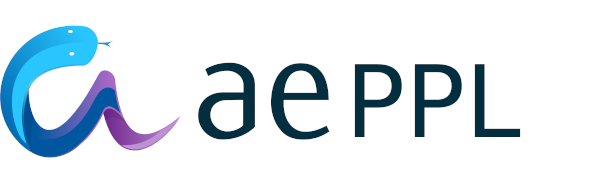

**Source code**
* [Aeppl [rev 2019114d23])](https://github.com/aesara-devs/aeppl/tree/2019114d231d8d3d96acc284fe0e6ee42d89c912/aeppl)
* [Aeppl logprob](https://github.com/aesara-devs/aeppl/blob/2019114d231d8d3d96acc284fe0e6ee42d89c912/aeppl/logprob.py)
* [Aeppl joint logprob](https://github.com/aesara-devs/aeppl/blob/2019114d231d8d3d96acc284fe0e6ee42d89c912/aeppl/joint_logprob.py)
* [Aeppl cumsum](https://github.com/aesara-devs/aeppl/blob/2019114d231d8d3d96acc284fe0e6ee42d89c912/aeppl/cumsum.py)
* [Aeppl mixture](https://github.com/aesara-devs/aeppl/blob/2019114d231d8d3d96acc284fe0e6ee42d89c912/aeppl/mixture.py)

In [ ]:
from aeppl import factorized_joint_logprob as aeppl_logp

In [ ]:
x = at.random.normal(name='x')
y = at.random.normal(x + 5, name='y', size=2)

x_value = at.scalar('x')
y_value = at.vector('y')
logp = aeppl_logp({x: x_value, y: y_value})
logp

In [ ]:
logp[y_value].eval({x_value: 5, y_value: [5, 10]})

## We are not limited to graphs defined in terms of random variables

In [ ]:
mu = at.random.normal(name='mu')
innov = at.random.normal(mu, size=10, name='innov')
rw = at.cumsum(innov); rw.name='rw'

mu_value = at.scalar('mu')
rw_value = at.vector('rw')
logp = aeppl_logp({mu: mu_value, rw: rw_value})
logp

In [ ]:
logp[rw_value].eval({mu_value: 1, rw_value: np.arange(10)})

In [ ]:
# Taking advantage of Aeppl to write a mixture model in PyMC
with pm.Model(coords={'trials': np.arange(10)}, rng_seeder=123) as m:
    
    idx = pm.Categorical('idx', p=[0.1, 0.3, 0.6], dims='trials')

    components = at.stack([
        pm.Laplace.dist(mu=-5, b=1),
        pm.Normal.dist(mu=0, sigma=1),
        pm.StudentT.dist(nu=7, mu=5, sigma=1),
    ])

    # Aeppl understands indexing of RandomVariables as Mixtures
    mix = components[idx]

    # Manual registration
    m.register_rv(mix, name='mix', dims='trials')

In [ ]:
# Taking advantage of Aeppl to write a mixture model in PyMC
with pm.Model(coords={'trials': np.arange(10)}, rng_seeder=123) as m:
    
    idx = pm.Categorical('idx', p=[0.1, 0.3, 0.6], dims='trials')

    components = at.stack([
        pm.Laplace.dist(mu=-5, b=1),
        pm.Normal.dist(mu=0, sigma=1),
        pm.StudentT.dist(nu=7, mu=5, sigma=1),
    ])

    # Aeppl understands indexing of RandomVariables as Mixtures
    mix = components[idx]

    # Manual registration
    m.register_rv(mix, name='mix', dims='trials')

In [ ]:
pm.model_to_graphviz(m)

In [ ]:
m.compute_initial_point(0)

In [ ]:
with m:
    prior = pm.sample_prior_predictive(return_inferencedata=False)

In [ ]:
prior['mix'].shape

In [ ]:
plt.hist(prior['mix'].reshape(-1), bins=50);

In [ ]:
# Same model but with observed
# We can't use dims... it breaks something in Aeppl, perhaps the SpecifyShape?
with pm.Model(coords={'trials': np.arange(10)}) as m:

    idx = pm.Categorical('idx', p=[0.1, 0.3, 0.6], size=10)

    components = at.stack([
        pm.Laplace.dist(mu=-5, b=1),
        pm.Normal.dist(mu=0, sigma=1),
        pm.StudentT.dist(nu=7, mu=5, sigma=1),
    ])

    mix = components[idx]

    # Now we pass data when we register the variable!
    m.register_rv(mix, name='mix', data=prior['mix'][0])

In [ ]:
m.point_logps()

In [ ]:
with m:
    trace = pm.sample(return_inferencedata=False)

In [ ]:
# Posterior indexes
np.median(trace['idx'], axis=0).astype(int)

In [ ]:
# True indexes
prior['idx'][0]

## What does aeppl support?
1. Dimshuffles, Broadcast, boring stuff
2. Indexing (mixtures)
3. Clipping (censoring)
4. Cumsum (random walks)
5. Scans (generalized time series)

### What is in the roadmap?
6. Deterministics (exp, log, add, ...)
7. Switch, IfElse (more mixtures)
8. Truncation
9. Ordering (sort, max, min, median...)
10. Arbitrary nesting of "derived" logp terms

### Other stuff
11. Automatic marginalization of latent variables
12. Removing normalization constants from logp graph


https://github.com/aesara-devs/aeppl/labels/enhancement

**NOTE: Many features are still experimental. Use with caution**

## Integration with PyMC

* PyMC Distributions return **RandomVariables** that Aeppl can always parse to obtain a logp graph.
* PyMC SymbolicDistributions return **arbitrary Aesara Variables** that we know Aeppl can always parse to obtain a logp graph
    * See [Censored distributions](https://github.com/pymc-devs/pymc/blob/1005d20b3c12d9b9a424c069f6a0f9962d73c41d/pymc/distributions/censored.py) for an example where we return `at.clip(RandomVariable, lower, upper)`